In [44]:
import pathlib
import numpy as np
from scipy.io import loadmat
import scipy.io
import os

#### Observations
- Each subject have same experiments done 
- Each subject have different number of voxels (So, It's hard to map them into one dataframe)
- Each subject have different number of unique labels (So, we can't use ungrouped data anywhere, only grouped data)

In [45]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder,
    MinMaxScaler,
    RobustScaler,
)
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.utils.validation import column_or_1d
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.datasets import load_iris
import numpy as np

In [46]:
import warnings

# Ignore warnings for collinearity, convergence, and dtype
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=Warning)


In [47]:
data_dir = "datasets\ML_brainData"
desktop = pathlib.Path(data_dir)

In [48]:
dataset = []
for i in list(desktop.iterdir()):
    dataset.append(loadmat(i))

In [49]:
#### Functions to convert the data into MNI and label them according to the MNI coordinates
def get_mni_coordinates(v):
    """
    Get MNI coordinates for an array of N voxels.

    Parameters:
        v (ndarray): Nx3 array of VOXEL COORDINATES (voxel space).

    Returns:
        ndarray: Nx3 array of MNI points.
    """
    # Transformation matrix from vox coord to MNI coord
    transformToXYZmm = np.array(
        [[-3.125, 0, 0, 81.250], [0, 3.125, 0, -115.625], [0, 0, 6, -54.000]]
    )

    # Append a column of ones to v
    ones_column = np.ones((v.shape[0], 1))
    v_homogeneous = np.hstack((v, ones_column))

    # Perform the transformation
    p = np.dot(v_homogeneous, transformToXYZmm.T)[:, :3]

    return p

In [50]:
file_dir = "datasets\ccbi_aal_atlas.mat"
atlas_data = scipy.io.loadmat(file_dir)
label_data = atlas_data["label"]
print("The shape of label data is:", label_data.shape)   # 1x117
print("The length of label data is:", len(label_data[0]))   # 117 

The shape of label data is: (1, 117)
The length of label data is: 117


In [51]:
def get_aal_labels(p):
    """
    Get AAL labels for an array of N MNI points (mm).

    Parameters:
        p (ndarray): Nx3 array of MNI points.

    Returns:
        list: List of AAL labels.
    """
    # Load AAL atlas
    atlas_data = scipy.io.loadmat(file_dir)
    vinv = atlas_data["vinv"]
    Y = atlas_data["Y"]
    label = atlas_data["label"]
    id = atlas_data["id"]

    # Initialize variables
    pv = np.zeros((p.shape[0], 4))
    z = np.zeros(p.shape[0], dtype=int)
    L = []

    # Get labels
    for j in range(p.shape[0]):
        pv[j, :] = np.round(np.append(p[j, :], 1))
        pv[j, :] = np.dot(pv[j, :], vinv.T)
        z[j] = Y[int(pv[j, 0]), int(pv[j, 1]), int(pv[j, 2])]
        L.append(label[np.where(id == z[j])][0])

    return L

In [52]:
mat_data = dataset[0]
Y_arr = []
resultData = mat_data["info"][0]
for i in range(0 , len(resultData)):
  Y_arr.append(resultData[i]["cond_number"][0])
Y_arr = np.array(Y_arr)
y = pd.DataFrame(Y_arr, columns=["cond_number"])
y

,cond_number
0,10
1,4
2,10
3,10
4,5
...,...
355,5
356,4
357,2
358,11


## Functions to make models

In [40]:
def train_and_evaluate_classifier(classifier, X, y, scaler):
    # Set up K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Create a pipeline with scaling, encoding, and classifier
    model_pipeline = Pipeline([("scaler", scaler), ("classifier", classifier)])

    # Perform cross-validation
    cross_val_results = cross_val_score(model_pipeline, X, y, cv=kf, scoring="accuracy")

    accuracy = cross_val_results.mean()
    error_rate = 1 - accuracy
    return accuracy, error_rate

In [53]:
def plot_results(classifier_shortnames, accuracy_results):
    x_labels = classifier_shortnames
    x = np.arange(len(x_labels))

    width = 0.95  # Adjust the width parameter to make the space between bars lesser

    fig, ax = plt.subplots(figsize=(6, 4))

    rects = ax.barh(
        x, accuracy_results, height=width, color="#48cae4", edgecolor="black"
    )  # Flip x and y axis

    ax.set_title("Accuracy Comparison")
    ax.set_xlabel("Accuracy (%)")  # Change y-axis label to x-axis label
    ax.set_yticks(x)  # Set y-ticks to x-values
    ax.set_yticklabels(x_labels, rotation=0)  # Set y-tick labels to x-labels

    ax.set_xlim([0, 100])  # Set the x-axis limits from 0 to 1

    def autolabel(rects):
        for rect in rects:
            width = rect.get_width()  # Change height to width
            ax.annotate(
                f"{width:.4f}%",  # Change height to width
                xy=(
                    width,
                    rect.get_y() + rect.get_height() / 2,
                ),  # Swap x and y coordinates
                xytext=(3, 0),  # Swap x and y offset
                textcoords="offset points",
                ha="left",  # Change ha to left
                va="center",  # Change va to center
            )

    autolabel(rects)

    fig.tight_layout()

    plt.show()

In [54]:
def model_blackbox(X, y):
    # Set up classifiers
    classifiers = [
        LinearDiscriminantAnalysis(),
        LogisticRegression(multi_class="ovr"),
        KNeighborsClassifier(n_neighbors=2),
        SGDClassifier(),
        RandomForestClassifier(n_estimators=100, random_state=42),
        GaussianNB(),
        SVC(),
    ]

    classifier_shortnames = [
        "LDA",
        "LR",
        "KNN",
        "SGD",
        "RF",
        "NB",
        "SVM",
    ]

    # Set up scalers
    scalers = [
        MinMaxScaler()
    ]  # we didn't use StandardScaler() and RobustScaler() because they are not suitable for our data

    for scaler in scalers:
        accuracy_results = []
        error_rate_results = []
        for classifier in classifiers:
            accuracy, error_rate = train_and_evaluate_classifier(
                classifier, X, y, scaler
            )
            accuracy_results.append(accuracy * 100)
            error_rate_results.append(error_rate * 100)
            print(
                f"{classifier.__class__.__name__}:\t\t Accuracy - {accuracy * 100:.6f}%\t, Error Rate - {error_rate * 100:.6f}%"
            )

        plot_results(classifier_shortnames, accuracy_results)

## Making models on the data

-----------------
The total coordinates are: 21764
The total unique labels are: 117
Labels to drop for person 1 is ['Cingulum_Ant_R', 'Amygdala_L', 'Frontal_Med_Orb_R', 'Cingulum_Ant_L', 'Frontal_Sup_Medial_R', 'Frontal_Sup_Medial_L', 'Amygdala_R', 'Vermis_3', 'Paracentral_Lobule_R', 'SupraMarginal_R', 'Vermis_1_2', 'Vermis_10', 'Temporal_Pole_Mid_L', 'Heschl_L', 'Temporal_Pole_Sup_L', 'Cerebelum_3_R', 'SupraMarginal_L', 'Putamen_R', 'ParaHippocampal_L', 'Heschl_R', 'Temporal_Pole_Mid_R', 'Cingulum_Mid_R', 'Cingulum_Mid_L', 'Pallidum_L', 'Cerebelum_Crus2_L', 'Insula_R', 'Vermis_8', 'Putamen_L', 'Angular_L', 'Cerebelum_10_L', 'ParaHippocampal_R', 'Cingulum_Post_R', 'Cerebelum_10_R', 'Rolandic_Oper_R', 'Cerebelum_9_L', 'Thalamus_R', 'Cerebelum_8_L', 'Postcentral_R', 'Paracentral_Lobule_L', 'Vermis_9', 'Frontal_Sup_R', 'Hippocampus_L', 'Insula_L', 'Precuneus_R', 'Temporal_Sup_L', 'Hippocampus_R', 'Cerebelum_9_R', 'Frontal_Sup_L', 'Temporal_Pole_Sup_R', 'Temporal_Sup_R', 'Pallidum_R', 'Rec

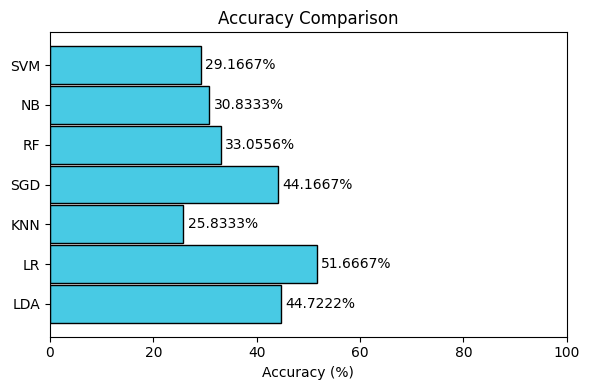

-----------------
-----------------
The total coordinates are: 21253
The total unique labels are: 115
Labels to drop for person 2 is ['Cerebelum_9_R', 'Cerebelum_Crus2_L', 'Cerebelum_9_L', 'Vermis_1_2', 'Vermis_10', 'Cerebelum_7b_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Post_R', 'Amygdala_L', 'Pallidum_R', 'Cerebelum_Crus2_R', 'Temporal_Pole_Sup_R', 'Angular_R', 'Frontal_Sup_Medial_L', 'Angular_L', 'Frontal_Sup_Medial_R', 'Cingulum_Mid_R', 'Putamen_R', 'Vermis_6', 'Cerebelum_8_R', 'Cerebelum_7b_L', 'Hippocampus_L', 'Cerebelum_Crus1_R', 'Heschl_L', 'Frontal_Sup_Orb_L', 'Parietal_Inf_R', 'Vermis_9', 'Caudate_L', 'Cerebelum_8_L', 'Vermis_3', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Thalamus_L', 'Cerebelum_10_R', 'Thalamus_R', 'Frontal_Med_Orb_R', 'Caudate_R', 'Vermis_4_5', 'Putamen_L', 'Olfactory_L', 'Paracentral_Lobule_L', 'Frontal_Sup_R', 'Precuneus_R', 'Frontal_Inf_Orb_R', 'Temporal_Pole_Sup_L', 'Cerebelum_3_R', 'Cingulum_Post_L', 'SupraMarginal_L', 'Frontal_Mid_L', 'SupraMargin

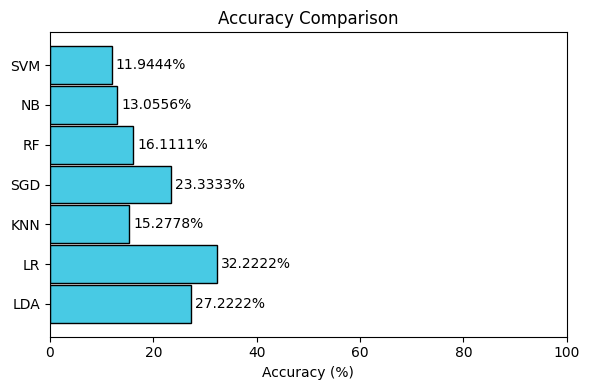

-----------------
-----------------
The total coordinates are: 20651
The total unique labels are: 115
Labels to drop for person 3 is ['Amygdala_L', 'Caudate_L', 'Amygdala_R', 'Caudate_R', 'Temporal_Pole_Sup_L', 'Temporal_Pole_Sup_R', 'Putamen_R', 'Olfactory_L', 'Parietal_Inf_R', 'Frontal_Sup_Medial_R', 'Thalamus_R', 'Putamen_L', 'SupraMarginal_R', 'Thalamus_L', 'SupraMarginal_L', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cerebelum_Crus2_L', 'Frontal_Sup_Medial_L', 'Pallidum_L', 'Insula_R', 'Insula_L', 'Cerebelum_9_L', 'Heschl_R', 'Cerebelum_7b_L', 'Frontal_Inf_Orb_R', 'Cerebelum_8_L', 'Frontal_Inf_Oper_R', 'Frontal_Med_Orb_R', 'Frontal_Mid_R', 'Paracentral_Lobule_R', 'Rolandic_Oper_L', 'Cingulum_Mid_R', 'Cerebelum_Crus2_R', 'Frontal_Inf_Orb_L', 'Angular_R', 'Frontal_Inf_Tri_R', 'Cerebelum_3_L', 'Rolandic_Oper_R', 'Cingulum_Post_R', 'Cerebelum_9_R', 'Hippocampus_L', 'Cerebelum_8_R', 'Paracentral_Lobule_L', 'Pallidum_R', 'Vermis_8', 'Temporal_Pole_Mid_R', 'Vermis_9', 'Cingulum_Mid_L', 'Fronta

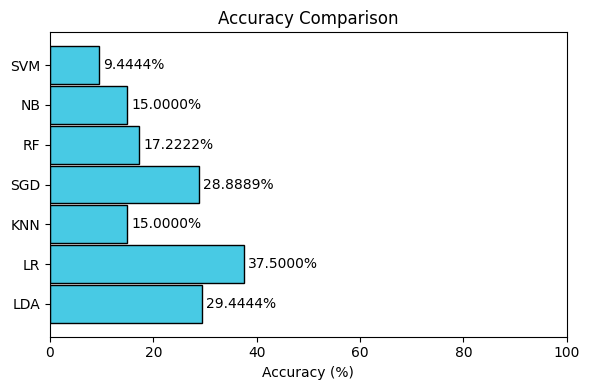

-----------------
-----------------
The total coordinates are: 20395
The total unique labels are: 114
Labels to drop for person 4 is ['Cerebelum_9_L', 'Vermis_1_2', 'Cerebelum_9_R', 'Cingulum_Post_R', 'Vermis_10', 'Angular_L', 'Angular_R', 'Cingulum_Post_L', 'Frontal_Med_Orb_R', 'Vermis_3', 'Olfactory_R', 'Rolandic_Oper_R', 'Vermis_4_5', 'Precuneus_R', 'Paracentral_Lobule_R', 'Cerebelum_4_5_R', 'Vermis_7', 'Precuneus_L', 'Vermis_6', 'Cingulum_Ant_R', 'Frontal_Sup_R', 'Cingulum_Mid_R', 'Putamen_R', 'SupraMarginal_R', 'Cingulum_Ant_L', 'Vermis_8', 'Cerebelum_Crus2_R', 'Amygdala_L', 'Frontal_Sup_Medial_R', 'ParaHippocampal_R', 'Cerebelum_Crus2_L', 'Hippocampus_L', 'Frontal_Mid_Orb_R', 'Hippocampus_R', 'Cingulum_Mid_L', 'Not_labelled', 'Postcentral_R', 'Insula_R', 'Frontal_Mid_Orb_L', 'Putamen_L', 'Pallidum_R', 'Cerebelum_3_R', 'Rectus_L', 'Thalamus_R', 'Frontal_Mid_R', 'Paracentral_Lobule_L', 'Caudate_L', 'Frontal_Sup_L', 'Pallidum_L', 'Temporal_Pole_Mid_L', 'Temporal_Mid_R', 'Cerebelum_7

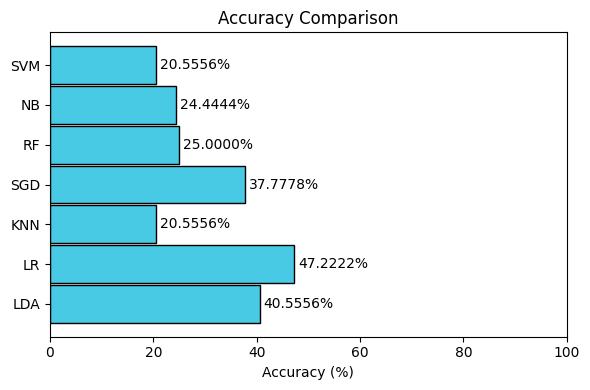

-----------------
-----------------
The total coordinates are: 20601
The total unique labels are: 112
Labels to drop for person 5 is ['Frontal_Med_Orb_R', 'Cingulum_Ant_R', 'Frontal_Sup_Medial_R', 'Frontal_Sup_Medial_L', 'Angular_L', 'Cingulum_Ant_L', 'Frontal_Inf_Orb_R', 'Cingulum_Post_R', 'Cerebelum_7b_L', 'Rectus_L', 'Precuneus_R', 'Cerebelum_Crus2_L', 'Angular_R', 'Frontal_Mid_Orb_R', 'Precuneus_L', 'Cerebelum_8_L', 'Frontal_Sup_Orb_R', 'Cingulum_Mid_R', 'Olfactory_R', 'Frontal_Mid_Orb_L', 'Cingulum_Post_L', 'Cerebelum_9_R', 'Temporal_Pole_Sup_R', 'Paracentral_Lobule_R', 'Cerebelum_9_L', 'Frontal_Mid_R', 'Parietal_Inf_R', 'Frontal_Mid_L', 'Heschl_R', 'Temporal_Pole_Mid_R', 'Frontal_Sup_L', 'Frontal_Sup_Orb_L', 'Vermis_8', 'Cerebelum_3_L', 'ParaHippocampal_L', 'Thalamus_R', 'Cingulum_Mid_L', 'Frontal_Sup_R', 'Cerebelum_Crus2_R', 'Vermis_3', 'Temporal_Sup_R', 'Parietal_Inf_L', 'Caudate_R', 'Temporal_Mid_L', 'Temporal_Mid_R', 'Insula_L', 'SupraMarginal_R', 'Thalamus_L', 'Heschl_L', 'V

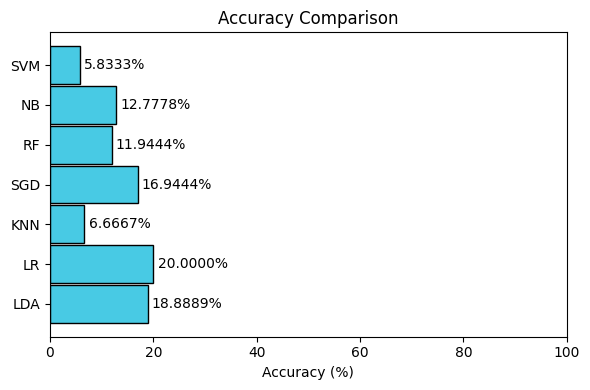

-----------------
-----------------
The total coordinates are: 19919
The total unique labels are: 107
Labels to drop for person 6 is ['Cerebelum_Crus2_R', 'Cuneus_R', 'Calcarine_L', 'Cuneus_L', 'Olfactory_R', 'Cerebelum_Crus2_L', 'Calcarine_R', 'Olfactory_L', 'Lingual_R', 'Precuneus_R', 'Frontal_Sup_Medial_R', 'Pallidum_L', 'Vermis_4_5', 'Cingulum_Ant_R', 'Angular_R', 'Vermis_7', 'Pallidum_R', 'ParaHippocampal_R', 'Cingulum_Post_R', 'Caudate_R', 'Cingulum_Ant_L', 'Cerebelum_4_5_R', 'Frontal_Sup_Medial_L', 'Rectus_R', 'Occipital_Sup_R', 'Vermis_6', 'Vermis_3', 'Occipital_Sup_L', 'Frontal_Sup_Orb_R', 'Cingulum_Post_L', 'Cerebelum_3_L', 'Heschl_R', 'Hippocampus_R', 'Vermis_1_2', 'Precuneus_L', 'Frontal_Sup_R', 'Cerebelum_Crus1_R', 'ParaHippocampal_L', 'Cingulum_Mid_R', 'Temporal_Pole_Mid_R', 'Temporal_Sup_R', 'Lingual_L', 'Putamen_R', 'Thalamus_R', 'Thalamus_L', 'Caudate_L', 'Angular_L', 'Frontal_Med_Orb_R', 'Temporal_Mid_R', 'Rectus_L', 'Temporal_Inf_L', 'Putamen_L', 'Cerebelum_3_R', 'Hi

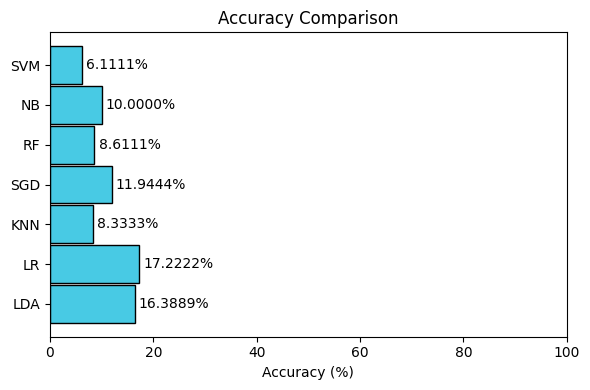

-----------------
-----------------
The total coordinates are: 19750
The total unique labels are: 103
Labels to drop for person 7 is ['Cerebelum_Crus2_R', 'Angular_R', 'Thalamus_R', 'Thalamus_L', 'Paracentral_Lobule_R', 'Vermis_3', 'Putamen_R', 'Pallidum_R', 'Caudate_L', 'Caudate_R', 'Putamen_L', 'Parietal_Inf_R', 'Frontal_Mid_Orb_R', 'SupraMarginal_R', 'Precuneus_R', 'Frontal_Sup_Orb_R', 'Frontal_Sup_Medial_R', 'Vermis_4_5', 'Frontal_Mid_R', 'Cingulum_Mid_R', 'Frontal_Sup_R', 'Frontal_Inf_Orb_R', 'Cingulum_Ant_R', 'Frontal_Sup_Medial_L', 'Cingulum_Mid_L', 'Frontal_Mid_L', 'Angular_L', 'Frontal_Inf_Oper_R', 'Paracentral_Lobule_L', 'Vermis_7', 'Cingulum_Ant_L', 'Frontal_Inf_Tri_R', 'Frontal_Med_Orb_R', 'Amygdala_R', 'Frontal_Sup_L', 'Insula_R', 'ParaHippocampal_L', 'Cerebelum_3_L', 'Frontal_Sup_Orb_L', 'Cerebelum_3_R', 'Olfactory_L', 'Temporal_Mid_R', 'Vermis_1_2', 'Parietal_Inf_L', 'Frontal_Inf_Tri_L', 'Cingulum_Post_R', 'Insula_L', 'Not_labelled', 'Hippocampus_L', 'Supp_Motor_Area_R',

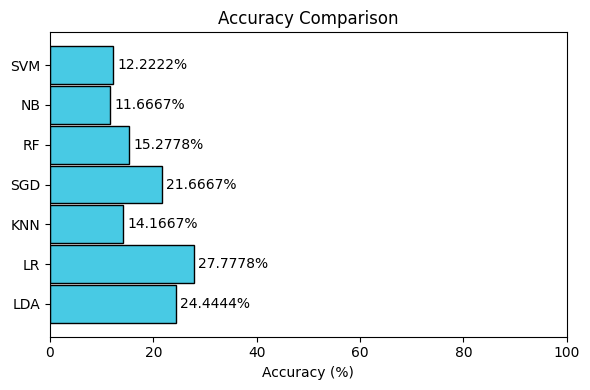

-----------------
-----------------
The total coordinates are: 20082
The total unique labels are: 113
Labels to drop for person 8 is ['Cerebelum_10_R', 'Vermis_10', 'Frontal_Mid_Orb_R', 'Pallidum_R', 'Frontal_Sup_Orb_L', 'SupraMarginal_R', 'Frontal_Sup_R', 'Amygdala_R', 'Cerebelum_9_L', 'Frontal_Sup_Medial_R', 'Parietal_Inf_R', 'Heschl_R', 'Insula_R', 'Parietal_Sup_R', 'ParaHippocampal_R', 'Frontal_Inf_Orb_R', 'Cerebelum_9_R', 'Precuneus_R', 'Frontal_Sup_Medial_L', 'Pallidum_L', 'Frontal_Mid_R', 'Temporal_Pole_Mid_R', 'Temporal_Mid_R', 'Putamen_R', 'Frontal_Mid_Orb_L', 'Cerebelum_3_R', 'Olfactory_L', 'Cerebelum_8_R', 'Cuneus_L', 'Frontal_Inf_Oper_R', 'Postcentral_R', 'Hippocampus_R', 'Temporal_Sup_R', 'Precuneus_L', 'Rolandic_Oper_R', 'Caudate_L', 'Frontal_Inf_Tri_R', 'Paracentral_Lobule_L', 'SupraMarginal_L', 'Cingulum_Post_R', 'Cingulum_Ant_L', 'Rolandic_Oper_L', 'Putamen_L', 'Frontal_Sup_L', 'Vermis_8', 'Heschl_L', 'Cingulum_Mid_L', 'Frontal_Med_Orb_R', 'Frontal_Mid_L', 'Cerebelum_8

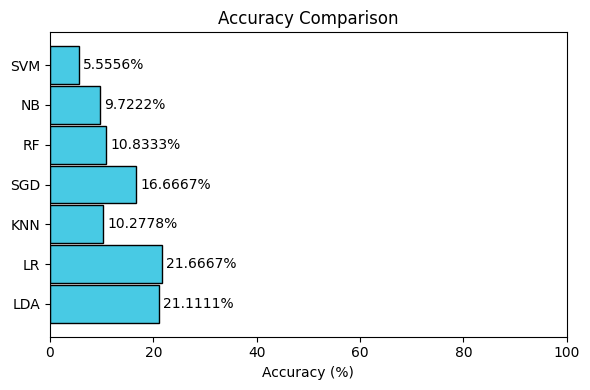

-----------------
-----------------
The total coordinates are: 21344
The total unique labels are: 116
Labels to drop for person 9 is ['Frontal_Mid_Orb_R', 'Vermis_10', 'Heschl_R', 'Vermis_9', 'Temporal_Pole_Mid_L', 'Olfactory_L', 'Frontal_Sup_Orb_R', 'Parietal_Inf_R', 'Cingulum_Ant_L', 'Cerebelum_9_L', 'Cingulum_Post_R', 'Cerebelum_9_R', 'Cerebelum_3_R', 'SupraMarginal_R', 'Pallidum_R', 'Cingulum_Ant_R', 'Thalamus_R', 'Rectus_L', 'Frontal_Med_Orb_R', 'Angular_R', 'Frontal_Sup_R', 'Rectus_R', 'Cerebelum_Crus2_L', 'Cerebelum_7b_L', 'Precuneus_R', 'ParaHippocampal_R', 'Olfactory_R', 'Frontal_Sup_Medial_R', 'Paracentral_Lobule_R', 'Cingulum_Post_L', 'Frontal_Inf_Oper_R', 'Cerebelum_8_L', 'Temporal_Pole_Mid_R', 'Frontal_Inf_Tri_R', 'ParaHippocampal_L', 'Pallidum_L', 'Frontal_Inf_Orb_R', 'Heschl_L', 'Hippocampus_R', 'Thalamus_L', 'Frontal_Sup_Orb_L', 'Frontal_Med_Orb_L', 'Temporal_Sup_L', 'Cerebelum_3_L', 'Hippocampus_L', 'Cingulum_Mid_L', 'Frontal_Mid_R', 'Vermis_3', 'Vermis_1_2', 'Rolandic

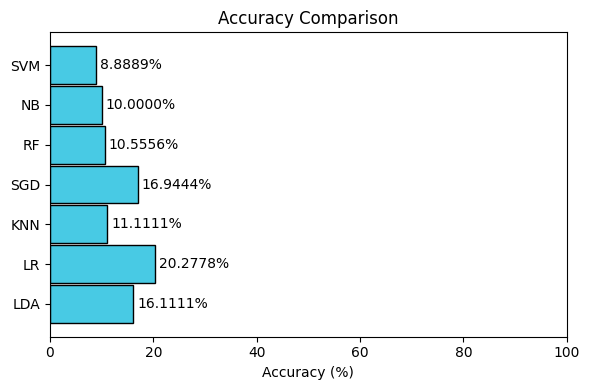

-----------------


In [55]:
final_X = []
for count_break, data_i in enumerate(dataset, start=1):
    print("-----------------")
    data = data_i["data"]
    arr = [data[i][0][0] for i in range(len(data))]
    DF_ungrouped = pd.DataFrame(np.array(arr))
    coordinates = data_i["meta"][0][0]["colToCoord"]
    print("The total coordinates are:", len(coordinates))
    MNI_coordinates = get_mni_coordinates(coordinates)
    AAL_labels = get_aal_labels(MNI_coordinates)
    print("The total unique labels are:", len(np.unique(AAL_labels)))
    AAL_labels_modified = [AAL_labels[i][0][0][0] for i in range(len(AAL_labels))]
    DF_ungrouped.loc["labels"] = AAL_labels_modified
    labels_row = DF_ungrouped.loc["labels"]
    DF_grouped = DF_ungrouped.groupby(labels_row, axis=1).mean()
    sums = DF_grouped.sum(axis=0)
    sorted_sums = sorted(sums.items(), key=lambda x: x[1])
    labels_to_drop = [label for label, _ in sorted_sums[:85]]
    print(f"Labels to drop for person {count_break} is {labels_to_drop}")
    labels = DF_ungrouped.loc["labels"]
    column_numbers = [i for i, label in enumerate(labels) if label in labels_to_drop]
    DF_ungrouped = DF_ungrouped.drop(DF_ungrouped.columns[column_numbers], axis=1)
    DF_ungrouped = DF_ungrouped.drop(["labels"])
    file_str = f"dataset_bestfeatures_person{count_break}.csv"
    DF_ungrouped.to_csv(file_str, index=False)
    Y_arr = [resultData[i]["cond_number"][0] for i in range(len(data_i["info"][0]))]
    y = pd.DataFrame(np.array(Y_arr), columns=["cond_number"])

    print(f"_________For Person {count_break}_________")

    model_blackbox(DF_ungrouped, y)

    print("-----------------")

-----------------
The total coordinates are: 21764
The total unique labels are: 117
dropping:  85
Labels to drop for person 1 is ['Cingulum_Ant_R', 'Amygdala_L', 'Frontal_Med_Orb_R', 'Cingulum_Ant_L', 'Frontal_Sup_Medial_R', 'Frontal_Sup_Medial_L', 'Amygdala_R', 'Vermis_3', 'Paracentral_Lobule_R', 'SupraMarginal_R', 'Vermis_1_2', 'Vermis_10', 'Temporal_Pole_Mid_L', 'Heschl_L', 'Temporal_Pole_Sup_L', 'Cerebelum_3_R', 'SupraMarginal_L', 'Putamen_R', 'ParaHippocampal_L', 'Heschl_R', 'Temporal_Pole_Mid_R', 'Cingulum_Mid_R', 'Cingulum_Mid_L', 'Pallidum_L', 'Cerebelum_Crus2_L', 'Insula_R', 'Vermis_8', 'Putamen_L', 'Angular_L', 'Cerebelum_10_L', 'ParaHippocampal_R', 'Cingulum_Post_R', 'Cerebelum_10_R', 'Rolandic_Oper_R', 'Cerebelum_9_L', 'Thalamus_R', 'Cerebelum_8_L', 'Postcentral_R', 'Paracentral_Lobule_L', 'Vermis_9', 'Frontal_Sup_R', 'Hippocampus_L', 'Insula_L', 'Precuneus_R', 'Temporal_Sup_L', 'Hippocampus_R', 'Cerebelum_9_R', 'Frontal_Sup_L', 'Temporal_Pole_Sup_R', 'Temporal_Sup_R', 'Pal

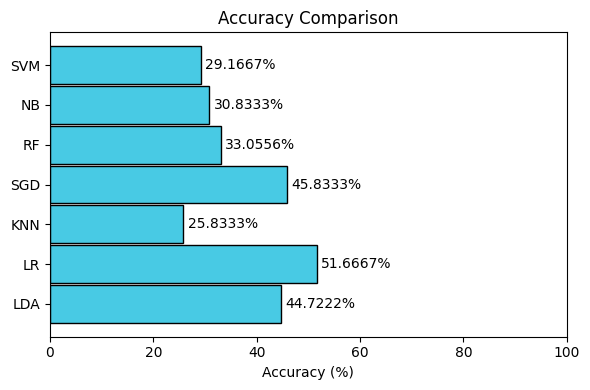

-----------------
-----------------
The total coordinates are: 21253
The total unique labels are: 115
dropping:  83
Labels to drop for person 2 is ['Cerebelum_9_R', 'Cerebelum_Crus2_L', 'Cerebelum_9_L', 'Vermis_1_2', 'Vermis_10', 'Cerebelum_7b_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Post_R', 'Amygdala_L', 'Pallidum_R', 'Cerebelum_Crus2_R', 'Temporal_Pole_Sup_R', 'Angular_R', 'Frontal_Sup_Medial_L', 'Angular_L', 'Frontal_Sup_Medial_R', 'Cingulum_Mid_R', 'Putamen_R', 'Vermis_6', 'Cerebelum_8_R', 'Cerebelum_7b_L', 'Hippocampus_L', 'Cerebelum_Crus1_R', 'Heschl_L', 'Frontal_Sup_Orb_L', 'Parietal_Inf_R', 'Vermis_9', 'Caudate_L', 'Cerebelum_8_L', 'Vermis_3', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Thalamus_L', 'Cerebelum_10_R', 'Thalamus_R', 'Frontal_Med_Orb_R', 'Caudate_R', 'Vermis_4_5', 'Putamen_L', 'Olfactory_L', 'Paracentral_Lobule_L', 'Frontal_Sup_R', 'Precuneus_R', 'Frontal_Inf_Orb_R', 'Temporal_Pole_Sup_L', 'Cerebelum_3_R', 'Cingulum_Post_L', 'SupraMarginal_L', 'Frontal_Mid_L'

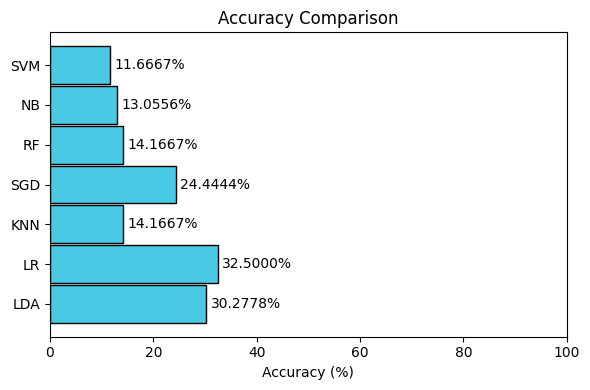

-----------------
-----------------
The total coordinates are: 20651
The total unique labels are: 115
dropping:  83
Labels to drop for person 3 is ['Amygdala_L', 'Caudate_L', 'Amygdala_R', 'Caudate_R', 'Temporal_Pole_Sup_L', 'Temporal_Pole_Sup_R', 'Putamen_R', 'Olfactory_L', 'Parietal_Inf_R', 'Frontal_Sup_Medial_R', 'Thalamus_R', 'Putamen_L', 'SupraMarginal_R', 'Thalamus_L', 'SupraMarginal_L', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cerebelum_Crus2_L', 'Frontal_Sup_Medial_L', 'Pallidum_L', 'Insula_R', 'Insula_L', 'Cerebelum_9_L', 'Heschl_R', 'Cerebelum_7b_L', 'Frontal_Inf_Orb_R', 'Cerebelum_8_L', 'Frontal_Inf_Oper_R', 'Frontal_Med_Orb_R', 'Frontal_Mid_R', 'Paracentral_Lobule_R', 'Rolandic_Oper_L', 'Cingulum_Mid_R', 'Cerebelum_Crus2_R', 'Frontal_Inf_Orb_L', 'Angular_R', 'Frontal_Inf_Tri_R', 'Cerebelum_3_L', 'Rolandic_Oper_R', 'Cingulum_Post_R', 'Cerebelum_9_R', 'Hippocampus_L', 'Cerebelum_8_R', 'Paracentral_Lobule_L', 'Pallidum_R', 'Vermis_8', 'Temporal_Pole_Mid_R', 'Vermis_9', 'Cingulum_M

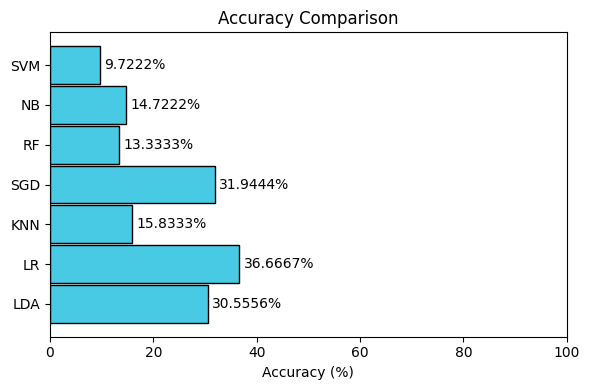

-----------------
-----------------
The total coordinates are: 20395
The total unique labels are: 114
dropping:  82
Labels to drop for person 4 is ['Cerebelum_9_L', 'Vermis_1_2', 'Cerebelum_9_R', 'Cingulum_Post_R', 'Vermis_10', 'Angular_L', 'Angular_R', 'Cingulum_Post_L', 'Frontal_Med_Orb_R', 'Vermis_3', 'Olfactory_R', 'Rolandic_Oper_R', 'Vermis_4_5', 'Precuneus_R', 'Paracentral_Lobule_R', 'Cerebelum_4_5_R', 'Vermis_7', 'Precuneus_L', 'Vermis_6', 'Cingulum_Ant_R', 'Frontal_Sup_R', 'Cingulum_Mid_R', 'Putamen_R', 'SupraMarginal_R', 'Cingulum_Ant_L', 'Vermis_8', 'Cerebelum_Crus2_R', 'Amygdala_L', 'Frontal_Sup_Medial_R', 'ParaHippocampal_R', 'Cerebelum_Crus2_L', 'Hippocampus_L', 'Frontal_Mid_Orb_R', 'Hippocampus_R', 'Cingulum_Mid_L', 'Not_labelled', 'Postcentral_R', 'Insula_R', 'Frontal_Mid_Orb_L', 'Putamen_L', 'Pallidum_R', 'Cerebelum_3_R', 'Rectus_L', 'Thalamus_R', 'Frontal_Mid_R', 'Paracentral_Lobule_L', 'Caudate_L', 'Frontal_Sup_L', 'Pallidum_L', 'Temporal_Pole_Mid_L', 'Temporal_Mid_R'

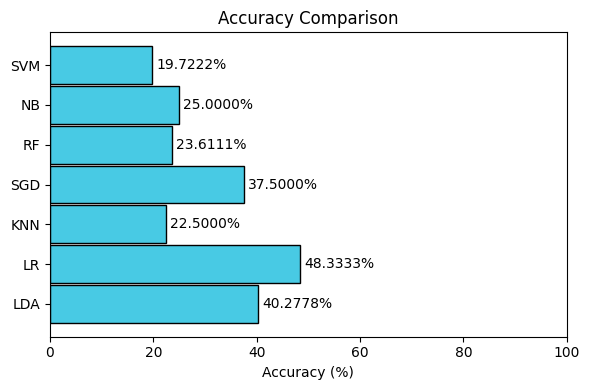

-----------------
-----------------
The total coordinates are: 20601
The total unique labels are: 112
dropping:  80
Labels to drop for person 5 is ['Frontal_Med_Orb_R', 'Cingulum_Ant_R', 'Frontal_Sup_Medial_R', 'Frontal_Sup_Medial_L', 'Angular_L', 'Cingulum_Ant_L', 'Frontal_Inf_Orb_R', 'Cingulum_Post_R', 'Cerebelum_7b_L', 'Rectus_L', 'Precuneus_R', 'Cerebelum_Crus2_L', 'Angular_R', 'Frontal_Mid_Orb_R', 'Precuneus_L', 'Cerebelum_8_L', 'Frontal_Sup_Orb_R', 'Cingulum_Mid_R', 'Olfactory_R', 'Frontal_Mid_Orb_L', 'Cingulum_Post_L', 'Cerebelum_9_R', 'Temporal_Pole_Sup_R', 'Paracentral_Lobule_R', 'Cerebelum_9_L', 'Frontal_Mid_R', 'Parietal_Inf_R', 'Frontal_Mid_L', 'Heschl_R', 'Temporal_Pole_Mid_R', 'Frontal_Sup_L', 'Frontal_Sup_Orb_L', 'Vermis_8', 'Cerebelum_3_L', 'ParaHippocampal_L', 'Thalamus_R', 'Cingulum_Mid_L', 'Frontal_Sup_R', 'Cerebelum_Crus2_R', 'Vermis_3', 'Temporal_Sup_R', 'Parietal_Inf_L', 'Caudate_R', 'Temporal_Mid_L', 'Temporal_Mid_R', 'Insula_L', 'SupraMarginal_R', 'Thalamus_L', 

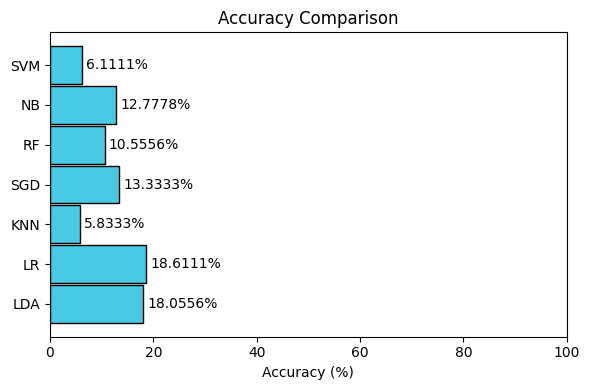

-----------------
-----------------
The total coordinates are: 19919
The total unique labels are: 107
dropping:  75
Labels to drop for person 6 is ['Cerebelum_Crus2_R', 'Cuneus_R', 'Calcarine_L', 'Cuneus_L', 'Olfactory_R', 'Cerebelum_Crus2_L', 'Calcarine_R', 'Olfactory_L', 'Lingual_R', 'Precuneus_R', 'Frontal_Sup_Medial_R', 'Pallidum_L', 'Vermis_4_5', 'Cingulum_Ant_R', 'Angular_R', 'Vermis_7', 'Pallidum_R', 'ParaHippocampal_R', 'Cingulum_Post_R', 'Caudate_R', 'Cingulum_Ant_L', 'Cerebelum_4_5_R', 'Frontal_Sup_Medial_L', 'Rectus_R', 'Occipital_Sup_R', 'Vermis_6', 'Vermis_3', 'Occipital_Sup_L', 'Frontal_Sup_Orb_R', 'Cingulum_Post_L', 'Cerebelum_3_L', 'Heschl_R', 'Hippocampus_R', 'Vermis_1_2', 'Precuneus_L', 'Frontal_Sup_R', 'Cerebelum_Crus1_R', 'ParaHippocampal_L', 'Cingulum_Mid_R', 'Temporal_Pole_Mid_R', 'Temporal_Sup_R', 'Lingual_L', 'Putamen_R', 'Thalamus_R', 'Thalamus_L', 'Caudate_L', 'Angular_L', 'Frontal_Med_Orb_R', 'Temporal_Mid_R', 'Rectus_L', 'Temporal_Inf_L', 'Putamen_L', 'Cereb

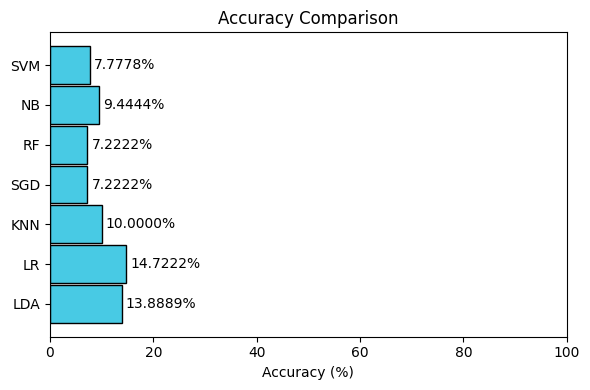

-----------------
-----------------
The total coordinates are: 19750
The total unique labels are: 103
dropping:  71
Labels to drop for person 7 is ['Cerebelum_Crus2_R', 'Angular_R', 'Thalamus_R', 'Thalamus_L', 'Paracentral_Lobule_R', 'Vermis_3', 'Putamen_R', 'Pallidum_R', 'Caudate_L', 'Caudate_R', 'Putamen_L', 'Parietal_Inf_R', 'Frontal_Mid_Orb_R', 'SupraMarginal_R', 'Precuneus_R', 'Frontal_Sup_Orb_R', 'Frontal_Sup_Medial_R', 'Vermis_4_5', 'Frontal_Mid_R', 'Cingulum_Mid_R', 'Frontal_Sup_R', 'Frontal_Inf_Orb_R', 'Cingulum_Ant_R', 'Frontal_Sup_Medial_L', 'Cingulum_Mid_L', 'Frontal_Mid_L', 'Angular_L', 'Frontal_Inf_Oper_R', 'Paracentral_Lobule_L', 'Vermis_7', 'Cingulum_Ant_L', 'Frontal_Inf_Tri_R', 'Frontal_Med_Orb_R', 'Amygdala_R', 'Frontal_Sup_L', 'Insula_R', 'ParaHippocampal_L', 'Cerebelum_3_L', 'Frontal_Sup_Orb_L', 'Cerebelum_3_R', 'Olfactory_L', 'Temporal_Mid_R', 'Vermis_1_2', 'Parietal_Inf_L', 'Frontal_Inf_Tri_L', 'Cingulum_Post_R', 'Insula_L', 'Not_labelled', 'Hippocampus_L', 'Supp_

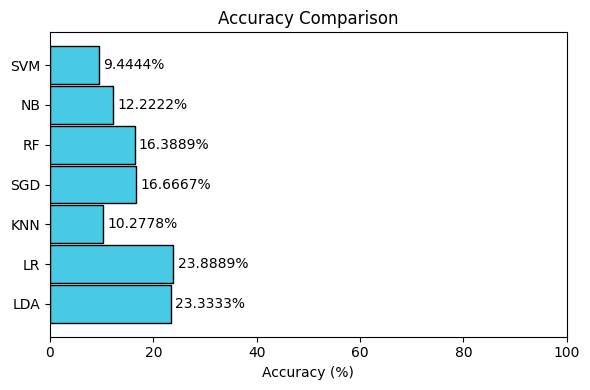

-----------------
-----------------
The total coordinates are: 20082
The total unique labels are: 113
dropping:  81
Labels to drop for person 8 is ['Cerebelum_10_R', 'Vermis_10', 'Frontal_Mid_Orb_R', 'Pallidum_R', 'Frontal_Sup_Orb_L', 'SupraMarginal_R', 'Frontal_Sup_R', 'Amygdala_R', 'Cerebelum_9_L', 'Frontal_Sup_Medial_R', 'Parietal_Inf_R', 'Heschl_R', 'Insula_R', 'Parietal_Sup_R', 'ParaHippocampal_R', 'Frontal_Inf_Orb_R', 'Cerebelum_9_R', 'Precuneus_R', 'Frontal_Sup_Medial_L', 'Pallidum_L', 'Frontal_Mid_R', 'Temporal_Pole_Mid_R', 'Temporal_Mid_R', 'Putamen_R', 'Frontal_Mid_Orb_L', 'Cerebelum_3_R', 'Olfactory_L', 'Cerebelum_8_R', 'Cuneus_L', 'Frontal_Inf_Oper_R', 'Postcentral_R', 'Hippocampus_R', 'Temporal_Sup_R', 'Precuneus_L', 'Rolandic_Oper_R', 'Caudate_L', 'Frontal_Inf_Tri_R', 'Paracentral_Lobule_L', 'SupraMarginal_L', 'Cingulum_Post_R', 'Cingulum_Ant_L', 'Rolandic_Oper_L', 'Putamen_L', 'Frontal_Sup_L', 'Vermis_8', 'Heschl_L', 'Cingulum_Mid_L', 'Frontal_Med_Orb_R', 'Frontal_Mid_L'

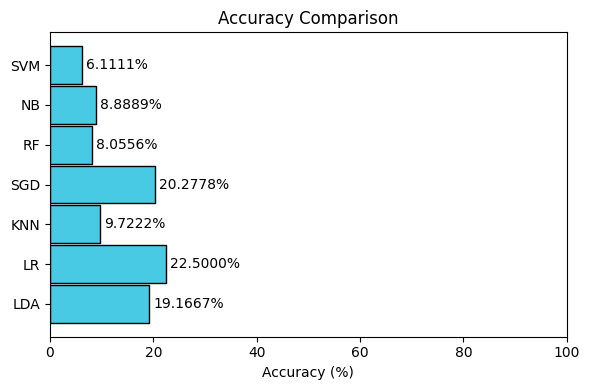

-----------------
-----------------
The total coordinates are: 21344
The total unique labels are: 116
dropping:  84
Labels to drop for person 9 is ['Frontal_Mid_Orb_R', 'Vermis_10', 'Heschl_R', 'Vermis_9', 'Temporal_Pole_Mid_L', 'Olfactory_L', 'Frontal_Sup_Orb_R', 'Parietal_Inf_R', 'Cingulum_Ant_L', 'Cerebelum_9_L', 'Cingulum_Post_R', 'Cerebelum_9_R', 'Cerebelum_3_R', 'SupraMarginal_R', 'Pallidum_R', 'Cingulum_Ant_R', 'Thalamus_R', 'Rectus_L', 'Frontal_Med_Orb_R', 'Angular_R', 'Frontal_Sup_R', 'Rectus_R', 'Cerebelum_Crus2_L', 'Cerebelum_7b_L', 'Precuneus_R', 'ParaHippocampal_R', 'Olfactory_R', 'Frontal_Sup_Medial_R', 'Paracentral_Lobule_R', 'Cingulum_Post_L', 'Frontal_Inf_Oper_R', 'Cerebelum_8_L', 'Temporal_Pole_Mid_R', 'Frontal_Inf_Tri_R', 'ParaHippocampal_L', 'Pallidum_L', 'Frontal_Inf_Orb_R', 'Heschl_L', 'Hippocampus_R', 'Thalamus_L', 'Frontal_Sup_Orb_L', 'Frontal_Med_Orb_L', 'Temporal_Sup_L', 'Cerebelum_3_L', 'Hippocampus_L', 'Cingulum_Mid_L', 'Frontal_Mid_R', 'Vermis_3', 'Vermis_1

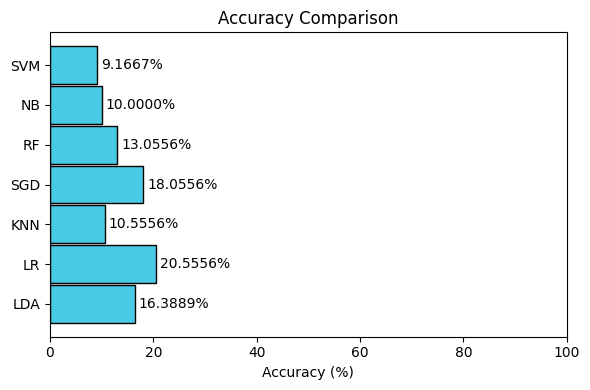

-----------------


In [56]:
final_X = []
for count_break, data_i in enumerate(dataset, start=1):
    print("-----------------")

    data = data_i["data"]
    arr = [data[i][0][0] for i in range(len(data))]
    DF_ungrouped = pd.DataFrame(np.array(arr))
    coordinates = data_i["meta"][0][0]["colToCoord"]
    print("The total coordinates are:", len(coordinates))

    MNI_coordinates = get_mni_coordinates(coordinates)
    AAL_labels = get_aal_labels(MNI_coordinates)
    print("The total unique labels are:", len(np.unique(AAL_labels)))

    AAL_labels_modified = [AAL_labels[i][0][0][0] for i in range(len(AAL_labels))]
    DF_ungrouped.loc["labels"] = AAL_labels_modified
    labels_row = DF_ungrouped.loc["labels"]
    DF_grouped = DF_ungrouped.groupby(labels_row, axis=1).mean()
    sums = DF_grouped.sum(axis=0)
    sums = sums.to_dict()
    sorted_sums = sorted(sums.items(), key=lambda x: x[1])
    var = len(np.unique(AAL_labels)) - 32
    print("dropping: ", var)

    labels_to_drop = [label for label, _ in sorted_sums[:var]]
    print(f"Labels to drop for person {count_break} is {labels_to_drop}")

    labels = DF_ungrouped.loc["labels"]
    column_numbers = [i for i, label in enumerate(labels) if label in labels_to_drop]
    DF_ungrouped = DF_ungrouped.drop(DF_ungrouped.columns[column_numbers], axis=1)
    DF_ungrouped = DF_ungrouped.drop(["labels"])
    file_str = f"dataset_bestfeatures_person{count_break}.csv"
    DF_ungrouped.to_csv(file_str, index=False)
    Y_arr = [resultData[i]["cond_number"][0] for i in range(len(data_i["info"][0]))]
    y = pd.DataFrame(np.array(Y_arr), columns=["cond_number"])

    print(f"_________For Person {count_break}_________")
    print("Dataset ", count_break)
    
    model_blackbox(DF_ungrouped, y)

    print("-----------------")

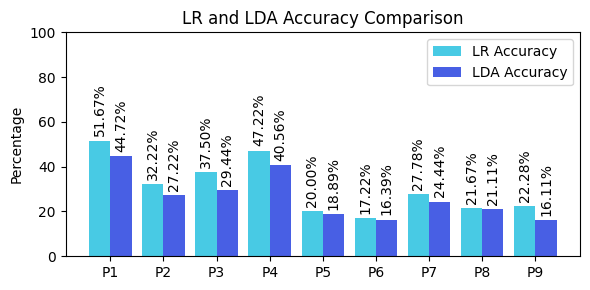

In [69]:
persons = ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9"]
LR_accuracy_list = [
    51.6667,
    32.2222,
    37.5000,
    47.2222,
    20.0000,
    17.2222,
    27.7778,
    21.6667,
    22.2778,
]
LDA_accuracy_list = [
    44.722,
    27.2222,
    29.4444,
    40.5556,
    18.8889,
    16.3889,
    24.4444,
    21.1111,
    16.1111,
]
# KNN_accuracy_list = []
# SGD_accuracy_list = []
# RF_accuracy_list = []
# NB_accuracy_list = []
# SVM_accuracy_list = []

x_labels = persons  # [str(classifier.__class__.__name__) for classifier in classifiers]
x = np.arange(len(x_labels))
width = 0.4

fig, ax = plt.subplots(figsize=(6, 3))
rects1 = ax.bar(
    x - width / 2, LR_accuracy_list, width, label="LR Accuracy", color="#48cae4"
)
rects2 = ax.bar(
    x + width / 2, LDA_accuracy_list, width, label="LDA Accuracy", color="#485fe4"
)

ax.set_ylim([0, 100])
ax.set_title("LR and LDA Accuracy Comparison")
ax.set_ylabel("Percentage")
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=0)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f"{height:.2f}%",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            rotation=90,
        )


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()